# 4. Findings
**Andrew Dang**  

**BrainStation, Data Science**  

**Previous Notebook: 3. Modeling

In the previous notebook, we fitted models with different text representation and ruleed out models that did not perform well. We landed on using Ridge regression with TF-IDF text representation. 

In this notebook, we will perform some model diagnostics first, and then investigate the results of our best model. We are looking to answer the questions we posed at the beginning of this project. 
1. Which words used by reviewers influence ratings positively and negatively?
2. Which flavours positively or negatively influence the whiskys' rating?

First, lets load in our packages, load our fitted models, and read in our data. 


In [1]:
# Basic data science packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data preprocessing packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('max_colwidth', 150)

# modeling and metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

# Utilities
import pickle
import joblib

# Model diagnostics
from scipy import stats

In [2]:
# Load data model was trained on. 
data = joblib.load('data/tfidf_df.pkl')

# Load in best model
best_ridge = joblib.load('fitted_models/rr_best.pkl')

***

## Model diagnostics 
1. Checking for homoscedasticity
2. Checking for normality

We need to check if our model violates any assumptions for linear regression models. If it has, we cannot trust the results or draw inferences from the results. 

We need to check the residuals to check for homoscedasticity, and normality. This means we need to make predictions on our test set and compare these predicted ratings to the actual ratings. Let's split the data first, and scale it as well, as the model was fitted on scaled data. 

In [3]:
# split data 
X = data.drop('review.point', axis=1)
y = data['review.point']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=88)

# scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Predictions using Ridge
ridge_preds = best_ridge.predict(X_test_scaled)

# Clip predictions
clip1 = np.where(ridge_preds < 0, 0, ridge_preds)
clip2 = np.where(clip1 > 100, 100, clip1)

# Put predicted ratings and actual ratings in a DataFrame
preds_vs_gt = pd.DataFrame({'GroundTruth': y_test,
                           'Prediction': clip2})

preds_vs_gt['residuals'] = preds_vs_gt['GroundTruth'] - preds_vs_gt['Prediction']
preds_vs_gt.head()

,GroundTruth,Prediction,residuals
861,88.0,89.413171,-1.413171
670,89.0,92.199089,-3.199089
563,90.0,89.780190,0.219810
1122,87.0,89.234548,-2.234548
1541,85.0,86.006236,-1.006236


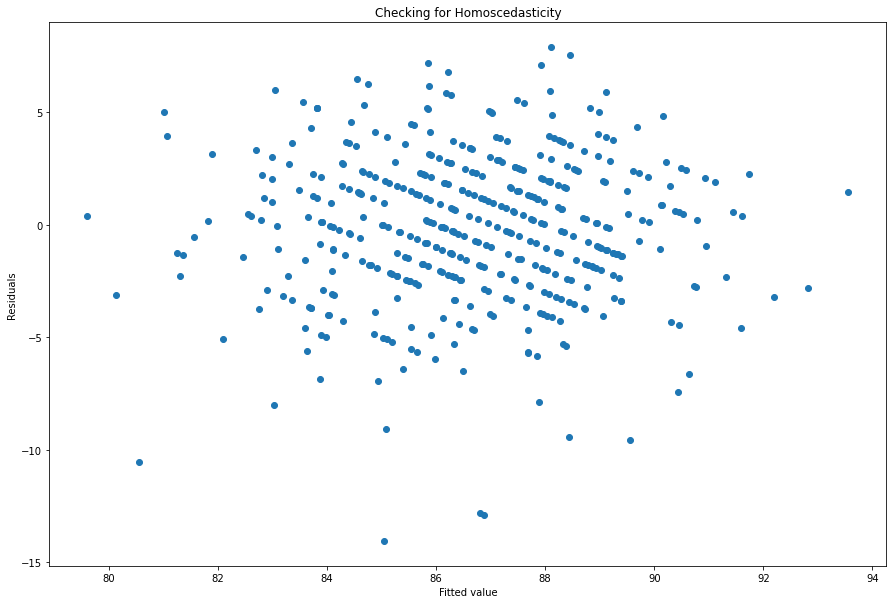

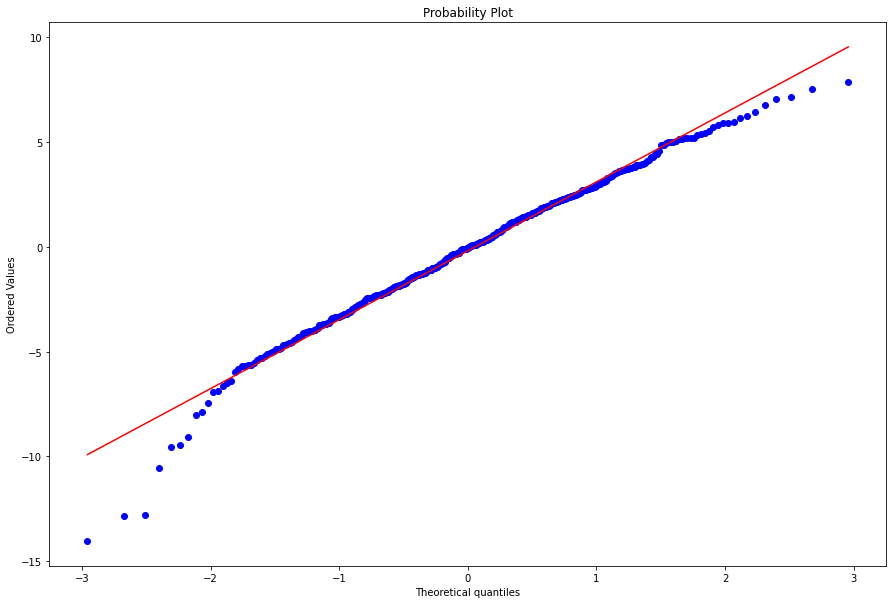

In [5]:
# plotting residuals - pred vs values
plt.figure(figsize=(15,10))
plt.scatter(preds_vs_gt['Prediction'], preds_vs_gt['residuals'])
plt.title('Checking for Homoscedasticity')
plt.ylabel('Residuals')
plt.xlabel('Fitted value')
plt.show()

# check for normaility
plt.figure(figsize=(15,10))
stats.probplot(preds_vs_gt['residuals'], dist="norm", plot = plt);
plt.show()

The variance of the residuals look to be equal, and so it doesn't violate homoscedasticity.  
Looking at the probabily plot, there is a bit of a tail on the negative end, but the majority of the data looks normal.  
***

## Model Evaluation: Comparing predicted ratings against actual ratings

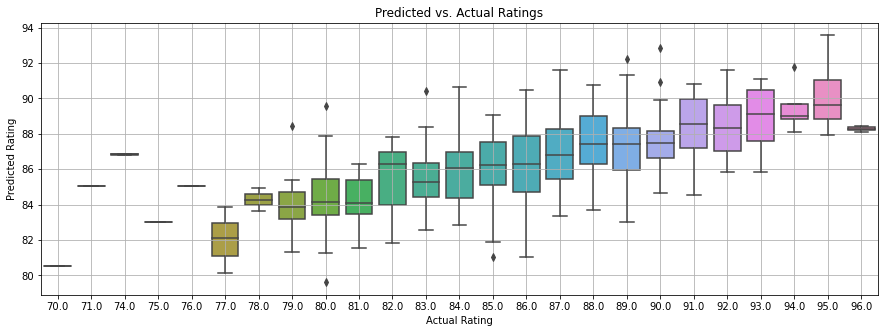

In [6]:
plt.figure(figsize=(15,5))
sns.boxplot(x=preds_vs_gt['GroundTruth'], y=preds_vs_gt['Prediction'])
plt.grid()
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs. Actual Ratings')
# plt.yticks(np.arange(74, 96, 2.0))
plt.show()

Despite the MAE being rather low (2.58), the variance of the predictions is pretty high. The model has a hard time predicting lower scores (below 80), though that may be due to not having lots of training data for low scoring whiskys.  

The model tends to overpredict whiskys with ratings under 87. Then it underestimates whiskys with ratings over 94. It seems to make consistently accurate predictions between the band of 88-93. 
***

## Inspecting regression coefficients

### Inspecting coefficients of words used in reviews
First, we will investigate the coefficients of the words used in reviews. We will place the name of the features and their coefficients in a DataFrame to make it easier to visualize later. 

To make it manageable to interpret, we will only look at the top 20 words with positive coefficients, and top 20 words with negative coefficients. 

In [7]:
# get features and coefficents
# Name of the training set columns are the name of the features
features = X_train.columns

# Coefficient values are from the model
coefs = best_ridge.coef_.ravel()

# Put feature names and their coefficients in a DataFrame
features_and_coef = pd.DataFrame({'Feature': features, 'Coef': coefs})

# Inspecting just the words; the last 7 rows are non-text data
words_and_coef = features_and_coef.iloc[:-7, :]

# get top 20 words
top20_words = words_and_coef.sort_values('Coef', ascending=False).head(20)
bot20_words = words_and_coef.sort_values('Coef', ascending=True).head(20)

### Plotting the top 20 words

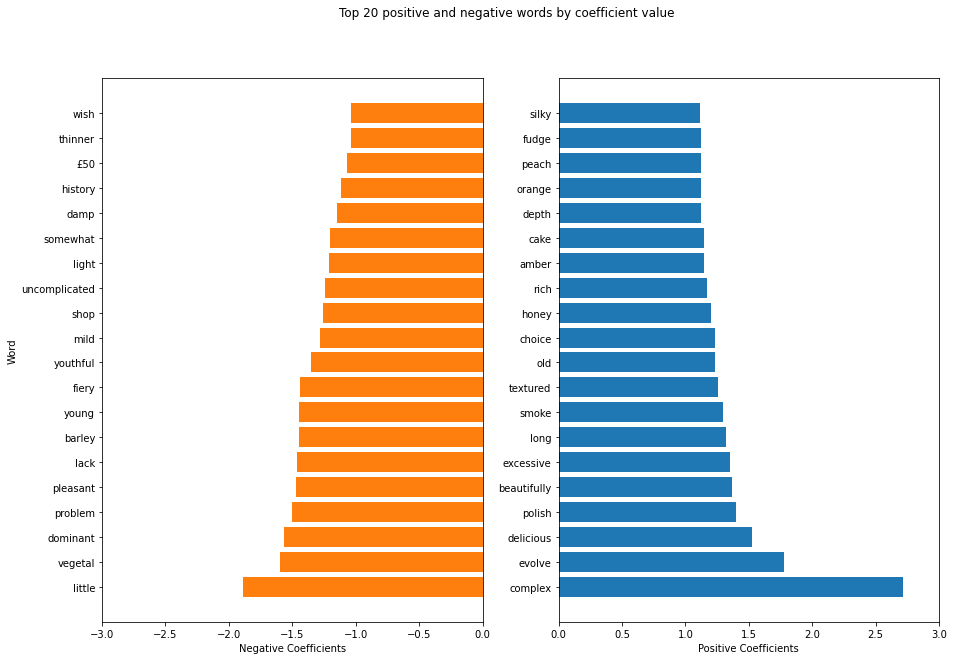

In [8]:
# plot top and bottom 20 words
plt.subplots(1,2, figsize=(15,10))
plt.subplot(1,2,1)
plt.barh(bot20_words['Feature'], bot20_words['Coef'], color='tab:orange' )
plt.xlim([-3,0])
plt.xlabel('Negative Coefficients')
plt.ylabel('Word')
plt.subplot(1,2,2)
plt.barh(top20_words['Feature'], top20_words['Coef'])
plt.xlim([0,3])
plt.xlabel('Positive Coefficients')
plt.suptitle('Top 20 positive and negative words by coefficient value')
plt.show()

### Positive coefficients
Flavours: fudge, orange, peach, cake, honey, smoke  
Refinement: depth, rich, textured, polish, complex   
Other: sliky, amber, choice, old, long, excessive, beatifully, delicious  

### Negative coefficients
Not enough: wish, somewhat, light, uncomplicated, mild, lack, little  
Too much: dominant  
Youthfulness: youthful, young  
Other adjectives: damp, fiery, vegetal  
Other: thinner, £50, history, shop, barley, problem   

### Interesting contrasts
Complex vs. uncomplicated  
Young vs. old  
Excessive instead of dominant  

There are many words with positive coefficients that describe a more refined drink with words like polish, or complex. On the other hand, there are many words with negative coefficients that either describe the whisky as having not enough or too much of a quality with words such as dominant, mild, or lack. This suggests that whisky follows the Goldilocks principle - too much or not enough of a quality lowers the rating, but having just the right amount of some quality positively influences the whisky's rating. 

There is an interesting contrast in words that describe age. 'Old' has a positive coefficient, whereas words like 'young' and 'youthful' have negative coefficients. This makes sense in terms of spirits, as it is often said that older spirits are preferred for having more mellow flavours. A similar contrast can be seen for 'complex' and 'uncomplicated'. 

## Inspecting coefficients of non-text features

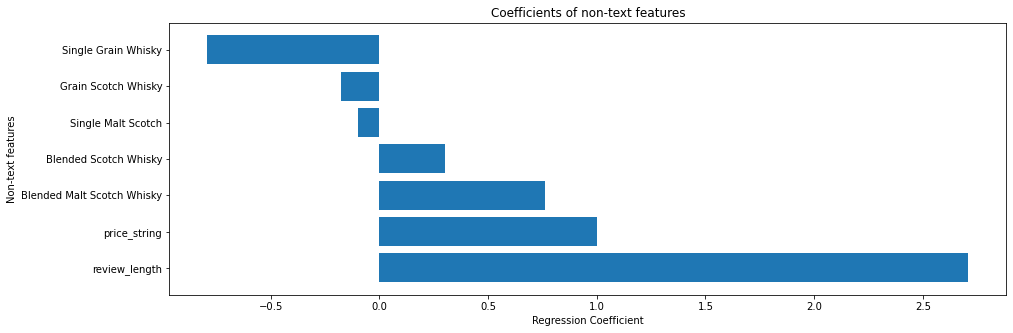

In [9]:
# Last seven features are non-text data
non_text_features = features_and_coef.iloc[-7:, :]

# get top 20 words
sorted_non_text = non_text_features.sort_values('Coef', ascending=False)

# Plot coefficient of non-text features
plt.figure(figsize=(15,5))
plt.barh(sorted_non_text['Feature'], sorted_non_text['Coef'])
plt.title('Coefficients of non-text features')
plt.xlabel('Regression Coefficient')
plt.ylabel('Non-text features')
plt.show()

Review length and the price have the most impact on the rating. Single malt whiskys are often perceived to be of higher quality, so it is surprisingly to see that, blended scotch whiskys and blended malt scotch whiskys had positive coefficients, while single malt and single grain whiskys had negative coefficients. 

***
## Actionable Insights
### Favourable flavours
Whiskey distilleries should try to craft whiskys that have fudge, orange, peach, cake, honey, or smoke flavours. These flavours had positive coefficients and perhaps having a spirit with these flavours will be positively received by whisky drinkers.

### Describing strong flavours
Looking at words to describe a flavour that is very strong, 'excessive' has a positive coefficient, whereas 'dominant' has a negative coefficient. Perhaps if a distiller wanted to describe their whisky as having a strong distinctive flavour of some sort, to use the word 'excessive' in place of 'dominant' would perhaps attract more attention from consumers. 

### Blended scotch whisky perform above expectation 
Single malt whiskys have the perception of being a higher quality spirit. However, when looking at the regression coefficients, single malt and single grain whisky's have negative coefficients, whereas blended whiskys have positive coefficients. This suggests that distilleries can 'get away' with producing blended whiskys. This is notable because blended whiskys are often cheaper to produce and require less aging, meaning that distilleries can get their product out to market faster.   


## Next steps
- Look beyond the top 20 positive and negative words to see if there are any additional interesting insights.   
- Cluster positive and negative words and see if there are any words that group together based on semantic meaning to reveal any common themes amongst positive and negative words.    
- Find reviews from more casual whisky drinkers and see if the language used by casual whisky drinkers is similar to the experts. 

- Optimize neural networks to see if we can get more accurate predictions.
- Interpret results of XGB Regressor - mainly looking at feature importance. 


